In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import datetime


linestyles = ['-', '--', '-.', ':']

In [2]:
def visualizeCorrelationPlot(dc, title=""):
    fig = plt.figure()
    plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(dc, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(dc.columns),1)
    ax.set_yticks(ticks)
    ticks = np.arange(0,len(dc.columns),1)
    ax.set_xticks(ticks)
    ax.set_yticklabels(dc.columns)    
    ax.set_xticklabels(dc.columns, rotation="vertical")
    ax.set_title(title)
    
    
    plt.show()

<br><br><br>
# Raw Traffic and Rolling & Expanding Traffic Visualization

In [3]:
rolling_expanding_bar = []

In [4]:
def getNeededFeatures(columns, arrFeaturesNeed=[], featureEngineering="Original"):
    to_remove = []
    if len(arrFeaturesNeed) == 0: #all features aren't needed
        return []
    else:
        if featureEngineering == "Original":
            compareTo = " "
        elif featureEngineering == "Rolling" or featureEngineering == "Expanding":
            compareTo = "_"
            
        for f in arrFeaturesNeed:
            for c in range(0, len(columns)):
                if (len(columns[c].split(compareTo)) <= 1 and featureEngineering != "Original"):
                    to_remove.append(c)
                if f not in columns[c].split(compareTo)[0] and columns[c].split(compareTo)[0] not in arrFeaturesNeed:
                    to_remove.append(c)
                if len(columns[c].split(compareTo)) > 1:
                    if "Esum" in columns[c].split(compareTo)[1]: #Removing all Expanding Sum 
                        to_remove.append(c)
                    if "min" in columns[c].split(compareTo)[1]: #Removing all Expanding Sum 
                        to_remove.append(c)
                    if "max" in columns[c].split(compareTo)[1]: #Removing all Expanding Sum 
                        to_remove.append(c)
                        
    return to_remove

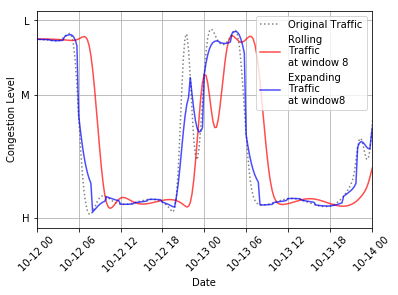

In [31]:
ROAD = "Vicente Cruz"
YEAR = "2015"
EXT = ".csv"
DATASET_DIVISION = "seasonWet"
DIR = "../../../../datasets/Thesis Datasets/"

ROLLING_WINDOW = 8
EXPANDING_WINDOW = 8

####################################### ORIG #######################################
TRAFFIC_WINDOWSIZE = 3
TRAFFIC_DIR = DIR + "mmda/"
TRAFFIC_FILENAME = "mmda_" + ROAD + "_" + YEAR + "_" + DATASET_DIVISION
orig_traffic = pd.read_csv(TRAFFIC_DIR + TRAFFIC_FILENAME + EXT, skipinitialspace=True)
orig_traffic = orig_traffic.fillna(0)

#Converting index to date and time, and removing 'dt' column
orig_traffic.index = pd.to_datetime(orig_traffic.dt, format='%d/%m/%Y %H:%M')
cols_to_remove = [0]
cols_to_remove = getNeededFeatures(orig_traffic.columns, ["statusN"])
orig_traffic.drop(orig_traffic.columns[[cols_to_remove]], axis=1, inplace=True)
orig_traffic.head()
####################################################################################


##################################### ROLLING #####################################
TRAFFIC_DIR = DIR + "mmda/Rolling/" + DATASET_DIVISION + "/"
TRAFFIC_FILENAME = "eng_win" + str(ROLLING_WINDOW) + "_mmda_" + ROAD + "_" + YEAR + "_" + DATASET_DIVISION
rolling_traffic = pd.read_csv(TRAFFIC_DIR + TRAFFIC_FILENAME + EXT, skipinitialspace=True)
cols_to_remove = [0, 1, 2]
cols_to_remove += getNeededFeatures(rolling_traffic.columns, ["statusN"], "Rolling")
rolling_traffic.index = pd.to_datetime(rolling_traffic.dt, format='%Y-%m-%d %H:%M')
rolling_traffic.drop(rolling_traffic.columns[[cols_to_remove]], axis=1, inplace=True)
rolling_traffic.head()
####################################################################################


##################################### EXPANDING #####################################
TRAFFIC_DIR = DIR + "mmda/Expanding/" + DATASET_DIVISION + "/"
TRAFFIC_FILENAME = "eng_win" + str(EXPANDING_WINDOW) + "_mmda_" + ROAD + "_" + YEAR + "_" + DATASET_DIVISION
expanding_traffic = pd.read_csv(TRAFFIC_DIR + TRAFFIC_FILENAME + EXT, skipinitialspace=True)
cols_to_remove = [0, 1, 2, 5]
cols_to_remove += getNeededFeatures(expanding_traffic.columns, ["statusN"], "Rolling")
expanding_traffic.index = pd.to_datetime(expanding_traffic.dt, format='%d/%m/%Y %H:%M')
expanding_traffic.drop(expanding_traffic.columns[[cols_to_remove]], axis=1, inplace=True)
####################################################################################




linestyles = ['-', '--', '-.', ':']


orig = orig_traffic[orig_traffic.columns[0]]
rolling = rolling_traffic[rolling_traffic.columns[0]]
expanding = expanding_traffic[expanding_traffic.columns[0]]

startIndex = 0
endIndex =  192

plt.plot(orig, color='gray', label="Original Traffic", linestyle=':')
plt.plot(rolling, color='r', alpha=0.7, label="Rolling \nTraffic \nat window " + str(ROLLING_WINDOW))
plt.plot(expanding, color='b', alpha=0.7, label='Expanding \nTraffic \nat window' + str(EXPANDING_WINDOW))
plt.legend(loc=1)


datemin = datetime.date(2015, 10, 12)
datemax = datetime.date(2015, 10, 14)
plt.xlim([datemin, datemax])
plt.xticks(rotation='45')
plt.xlabel("Date")
plt.yticks([0, 0.625, 1], ["H", "M", "L"])
plt.ylabel("Congestion Level")
plt.grid()

plt.show()

<br><br><br>
# Correlation 'growth' of Rolling with Current Traffic

Text(0.5,1,'Correlation between Rolling with Current Northbound Traffic')

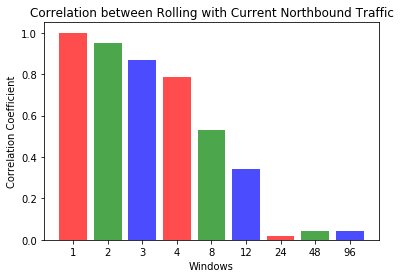

In [6]:
merged_traffic = pd.concat([orig_traffic, 
                            orig_traffic.shift(1).rolling(2).mean(),
                            orig_traffic.shift(2).rolling(3).mean(),
                            orig_traffic.shift(3).rolling(4).mean(),
                            orig_traffic.shift(7).rolling(8).mean(),
                            orig_traffic.shift(11).rolling(12).mean(),
                            orig_traffic.shift(23).rolling(24).mean(),
                            orig_traffic.shift(47).rolling(48).mean(),
                            orig_traffic.shift(95).rolling(96).mean(),
                           ], axis=1)

merged = merged_traffic.corr(method='spearman').iloc[:, 0].values
rolling_expanding_bar.append(merged)
plt.bar(np.arange(len(merged)), merged, align='center', alpha=0.7, color=['r', 'g', 'b'])

windows = [1, 2, 3, 4, 8, 12, 24, 48, 96]
plt.xticks(np.arange(len(windows)), windows)
plt.xlabel("Windows")
plt.ylabel("Correlation Coefficient")
plt.title("Correlation between Rolling with Current Northbound Traffic")

<br><br><br>
# Correlation 'growth' of Expanding with Current Traffic

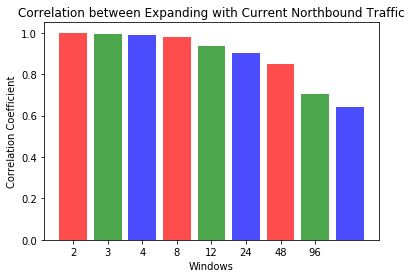

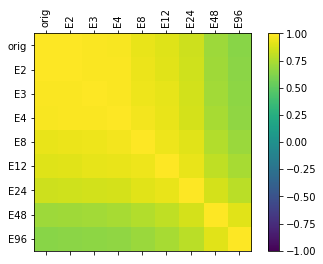

<Figure size 1440x1440 with 0 Axes>

,orig,E2,E3,E4,E8,E12,E24,E48,E96
orig,1.000000,0.995798,0.988118,0.978788,0.934377,0.903967,0.849404,0.706457,0.640689
E2,0.995798,1.000000,0.991277,0.986409,0.944335,0.913571,0.858267,0.716008,0.649803
E3,0.988118,0.991277,1.000000,0.986189,0.951216,0.923018,0.866965,0.725699,0.659216
E4,0.978788,0.986409,0.986189,1.000000,0.963486,0.931607,0.874712,0.734846,0.668215
E8,0.934377,0.944335,0.951216,0.963486,1.000000,0.951950,0.906404,0.770422,0.701326
E12,0.903967,0.913571,0.923018,0.931607,0.951950,1.000000,0.935956,0.808856,0.734959
E24,0.849404,0.858267,0.866965,0.874712,0.906404,0.935956,1.000000,0.867962,0.790194
E48,0.706457,0.716008,0.725699,0.734846,0.770422,0.808856,0.867962,1.000000,0.911182
E96,0.640689,0.649803,0.659216,0.668215,0.701326,0.734959,0.790194,0.911182,1.000000


In [7]:
windows = [2, 3, 4, 8, 12, 24, 48, 96]
expanding_traffic_list= []
for w in windows:
    EXPANDING_WINDOW = w
    ##################################### EXPANDING #####################################
    TRAFFIC_DIR = DIR + "mmda/Expanding/" + DATASET_DIVISION + "/"
    TRAFFIC_FILENAME = "eng_win" + str(EXPANDING_WINDOW) + "_mmda_" + ROAD + "_" + YEAR + "_" + DATASET_DIVISION
    expanding_traffic = pd.read_csv(TRAFFIC_DIR + TRAFFIC_FILENAME + EXT, skipinitialspace=True)
    cols_to_remove = [0, 1, 2, 5]
    cols_to_remove += getNeededFeatures(expanding_traffic.columns, ["statusN"], "Rolling")
    expanding_traffic.index = pd.to_datetime(expanding_traffic.dt, format='%d/%m/%Y %H:%M')
    expanding_traffic.drop(expanding_traffic.columns[[cols_to_remove]], axis=1, inplace=True)
    ####################################################################################
    temp = pd.DataFrame(data=expanding_traffic.iloc[:,0].values, columns=['E'+str(w)])
    expanding_traffic_list.append(temp)
    
#Adding orig traffic
expanding_traffic_list.insert(0, pd.DataFrame(data=orig_traffic.iloc[:, 0].values, columns=['orig']))
expanding_traffic_list

merged = pd.concat(expanding_traffic_list, axis=1)
merged_expanding = merged
merged_corr = merged.corr(method='spearman').iloc[:, 0].values
rolling_expanding_bar.append(merged_corr)
plt.bar(np.arange(len(merged_corr)), merged_corr, align='center', alpha=0.7, color=['r', 'g', 'b'])
plt.xticks(np.arange(len(windows)), windows)
plt.xlabel("Windows")
plt.ylabel("Correlation Coefficient")
plt.title("Correlation between Expanding with Current Northbound Traffic")

visualizeCorrelationPlot(merged.corr(method='spearman'), title="")

merged.corr(method='spearman')

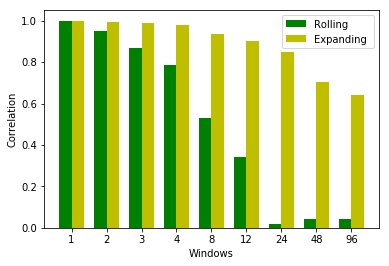

[1.         0.95158013 0.8694528  0.78415398 0.52802914 0.3435478
 0.0161945  0.04070479 0.04349559]
[1.         0.99579757 0.98811821 0.97878796 0.93437747 0.90396711
 0.84940366 0.70645702 0.64068864]


In [26]:
windows = [1, 2, 3, 4, 8, 12, 24, 48, 96]
rolling = rolling_expanding_bar[0]
expanding = rolling_expanding_bar[1]

ind = np.arange(len(rolling))  # the x locations for the groups
width = 0.35      # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(ind, rolling, width, color='g')
rects2 = ax.bar(ind + width, expanding, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('Correlation')
ax.set_xlabel('Windows')
# ax.set_title('Correlation of Expanding and Rolling Traffic to Current Traffic by window')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((windows))


ax.legend((rects1[0], rects2[0]), 
          ('Rolling', 
           'Expanding '))


plt.show()

print(rolling_expanding_bar[0])
print(rolling_expanding_bar[1])

<br><br><br>
# Correlating Rolling and Expanding Traffic

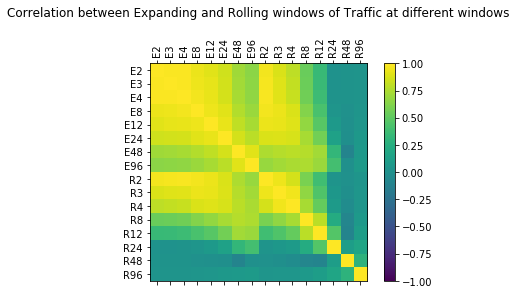

<Figure size 1440x1440 with 0 Axes>

,E2,E3,E4,E8,E12,E24,E48,E96,R2,R3,R4,R8,R12,R24,R48,R96
E2,1.000000,0.991277,0.986409,0.944335,0.913571,0.858267,0.716008,0.649803,0.962605,0.883423,0.798137,0.539709,0.348792,0.017576,0.030118,0.037618
E3,0.991277,1.000000,0.986189,0.951216,0.923018,0.866965,0.725699,0.659216,0.972707,0.898474,0.814474,0.554088,0.359096,0.022210,0.026950,0.037218
E4,0.986409,0.986189,1.000000,0.963486,0.931607,0.874712,0.734846,0.668215,0.979261,0.912447,0.829822,0.567967,0.369021,0.025885,0.023630,0.037561
E8,0.944335,0.951216,0.963486,1.000000,0.951950,0.906404,0.770422,0.701326,0.967994,0.945073,0.886652,0.630047,0.427174,0.044167,0.008002,0.045442
E12,0.913571,0.923018,0.931607,0.951950,1.000000,0.935956,0.808856,0.734959,0.941735,0.934502,0.899100,0.678004,0.480003,0.074866,0.000130,0.048753
E24,0.858267,0.866965,0.874712,0.906404,0.935956,1.000000,0.867962,0.790194,0.886862,0.893989,0.881114,0.740122,0.570621,0.142707,-0.003749,0.062621
E48,0.716008,0.725699,0.734846,0.770422,0.808856,0.867962,1.000000,0.911182,0.752056,0.779350,0.794100,0.780294,0.721760,0.324027,-0.095299,0.081363
E96,0.649803,0.659216,0.668215,0.701326,0.734959,0.790194,0.911182,1.000000,0.687522,0.722640,0.746310,0.754812,0.699778,0.401642,0.002785,0.087858
R2,0.962605,0.972707,0.979261,0.967994,0.941735,0.886862,0.752056,0.687522,1.000000,0.951638,0.872061,0.600388,0.390114,0.036037,0.012538,0.041742
R3,0.883423,0.898474,0.912447,0.945073,0.934502,0.893989,0.779350,0.722640,0.951638,1.000000,0.953783,0.670036,0.450900,0.060308,-0.007468,0.047851


In [9]:
windows = [2, 3, 4, 8, 12, 24, 48, 96]
 
expanding_traffic_list= []
rolling_traffic_list= []

for w in windows:
    EXPANDING_WINDOW = w
    ##################################### EXPANDING #####################################
    TRAFFIC_DIR = DIR + "mmda/Expanding/" + DATASET_DIVISION + "/"
    TRAFFIC_FILENAME = "eng_win" + str(EXPANDING_WINDOW) + "_mmda_" + ROAD + "_" + YEAR + "_" + DATASET_DIVISION
    expanding_traffic = pd.read_csv(TRAFFIC_DIR + TRAFFIC_FILENAME + EXT, skipinitialspace=True)
    cols_to_remove = [0, 1, 2, 5]
    cols_to_remove += getNeededFeatures(expanding_traffic.columns, ["statusN"], "Rolling")
    expanding_traffic.index = pd.to_datetime(expanding_traffic.dt, format='%d/%m/%Y %H:%M')
    expanding_traffic.drop(expanding_traffic.columns[[cols_to_remove]], axis=1, inplace=True)
    ####################################################################################
    temp = pd.DataFrame(data=expanding_traffic.iloc[:,0].values, columns=['E'+str(w)])
    expanding_traffic_list.append(temp)
    

    ROLLING_WINDOW = w
    ##################################### ROLLING #####################################
    TRAFFIC_DIR = DIR + "mmda/Rolling/" + DATASET_DIVISION + "/"
    TRAFFIC_FILENAME = "eng_win" + str(ROLLING_WINDOW) + "_mmda_" + ROAD + "_" + YEAR + "_" + DATASET_DIVISION
    rolling_traffic = pd.read_csv(TRAFFIC_DIR + TRAFFIC_FILENAME + EXT, skipinitialspace=True)
    cols_to_remove = [0, 1, 2]
    cols_to_remove += getNeededFeatures(rolling_traffic.columns, ["statusN"], "Rolling")
    rolling_traffic.index = pd.to_datetime(rolling_traffic.dt, format='%Y-%m-%d %H:%M')
    rolling_traffic.drop(rolling_traffic.columns[[cols_to_remove]], axis=1, inplace=True)
    ####################################################################################
    temp = pd.DataFrame(data=rolling_traffic.iloc[:,0].values, columns=['R'+str(w)])
    rolling_traffic_list.append(temp)

merged_expanding_corr = pd.concat(expanding_traffic_list, axis=1)
merged_rolling_corr = pd.concat(rolling_traffic_list, axis=1)
merged_corr = pd.concat([merged_expanding_corr, merged_rolling_corr], axis=1)
#Array to Dataframe
merged_corr = merged_corr.corr(method='spearman')
visualizeCorrelationPlot(merged_corr, title="Correlation between Expanding and Rolling windows of Traffic at different windows\n\n")

merged_corr

<br><br><br>
# PM1 Yesterday - Today FE + Connected Roads

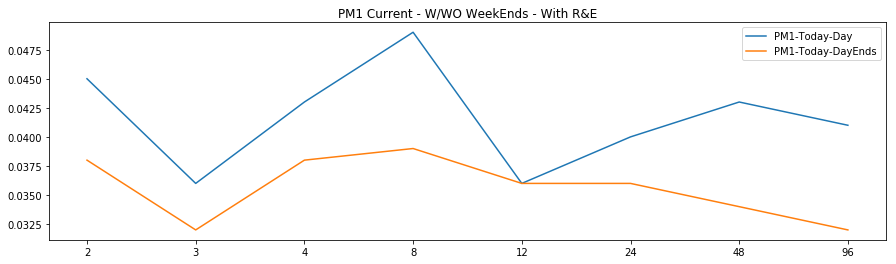

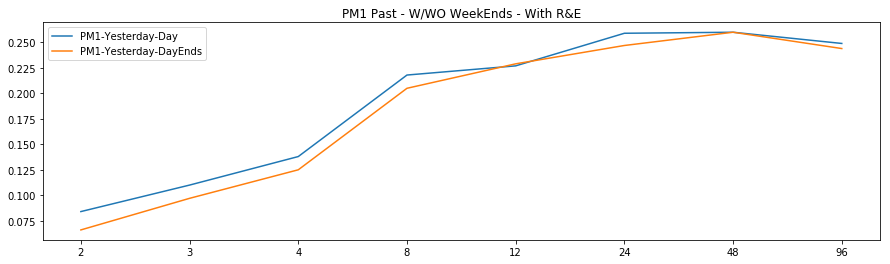

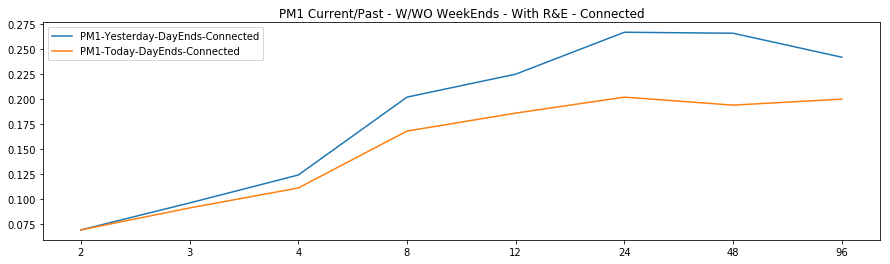

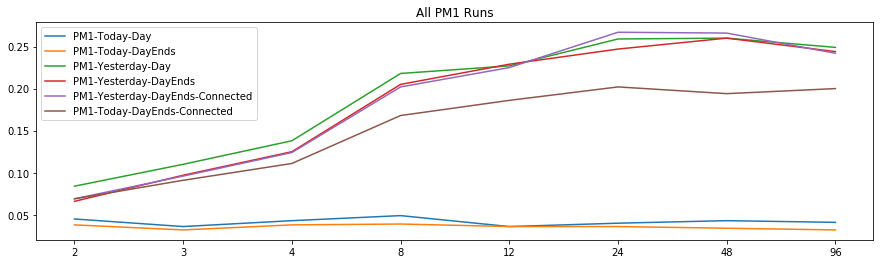

In [10]:
#Experiments Comparison for all windows
line1 = [0.084, 0.110, 0.138, 0.218, 0.227, 0.259,  0.260, 0.249] #PM1 - Yesterday - Weekday
line2 = [0.066, 0.097, 0.125, 0.205, 0.229, 0.247, 0.260, 0.244] #PM1 - Yesterday - WeekdayWeekends
line3 = [0.045, 0.036, 0.043, 0.049, 0.036, 0.040, 0.043, 0.041] #PM1 - Today - Weekday
line4 = [0.038, 0.032, 0.038, 0.039, 0.036, 0.036, 0.034, 0.032] #PM1 - Today - WeekdayWeekends
line5 = [0.069, 0.096, 0.124, 0.202, 0.225, 0.267, 0.266, 0.242] #PM1 - Yesterday - Connected Roads - Weekday
line6 = [0.069, 0.091, 0.111, 0.168, 0.186, 0.202, 0.194, 0.200] #PM1 - Yesterday - Connected Roads - WeekdayWeekends
windows = [2,     3,     4,     8,     12,    24,    48,   96]

plt.figure(figsize=(15, 4))
plt.title("PM1 Current - W/WO WeekEnds - With R&E")
plt.plot(line3, label="PM1-Today-Day")
plt.plot(line4, label="PM1-Today-DayEnds")
plt.legend()
plt.xticks(range(len(windows)), (windows))

plt.figure(figsize=(15, 4))
plt.title("PM1 Past - W/WO WeekEnds - With R&E")
plt.plot(line1, label="PM1-Yesterday-Day")
plt.plot(line2, label="PM1-Yesterday-DayEnds")
plt.legend()
plt.xticks(range(len(windows)), (windows))

plt.figure(figsize=(15, 4))
plt.title("PM1 Current/Past - W/WO WeekEnds - With R&E - Connected")
plt.plot(line5, label="PM1-Yesterday-DayEnds-Connected")
plt.plot(line6, label="PM1-Today-DayEnds-Connected")
plt.legend()
plt.xticks(range(len(windows)), (windows))


plt.figure(figsize=(15, 4))
plt.title("All PM1 Runs")
plt.plot(line3, label="PM1-Today-Day")
plt.plot(line4, label="PM1-Today-DayEnds")
plt.plot(line1, label="PM1-Yesterday-Day")
plt.plot(line2, label="PM1-Yesterday-DayEnds")
plt.plot(line5, label="PM1-Yesterday-DayEnds-Connected")
plt.plot(line6, label="PM1-Today-DayEnds-Connected")
plt.legend()
plt.xticks(range(len(windows)), (windows))



plt.show()

<br><br><br>
# PM1 Windows

### PM1 Windows without WP

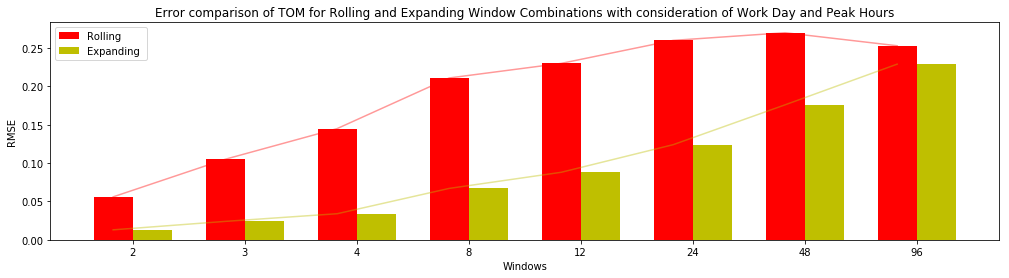

In [11]:
windows = [2, 3, 4, 8, 12, 24, 48, 96]
pm1_rolling = [0.056, 0.105, 0.145, 0.211, 0.23, 0.26, 0.27, 0.253]
pm1_expanding = [0.013, 0.024, 0.034, 0.067, 0.088, 0.124, 0.176, 0.229]
pm1_rolling_wp = [0.063, 0.11, 0.145, 0.21, 0.217, 0.245, 0.257, 0.242]
pm1_expanding_wp = [0.023, 0.03, 0.039, 0.069, 0.087, 0.121, 0.172, 0.205]

ind = np.arange(len(pm1_rolling))  # the x locations for the groups
width = 0.35      # the width of the bars

fig, ax = plt.subplots(figsize=(17,4))

rects1 = ax.bar(ind, pm1_rolling, width, color='r')
ax.plot(pm1_rolling, color='r', alpha=0.4)


rects2 = ax.bar(ind + width, pm1_expanding, width, color='y')
ax.plot(pm1_expanding, color='y', alpha=0.4)

# add some text for labels, title and axes ticks
ax.set_ylabel('RMSE')
ax.set_xlabel('Windows')
ax.set_title('Error comparison of TOM for Rolling and Expanding Window Combinations with consideration of Work Day and Peak Hours')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((windows))


ax.legend((rects1[0], rects2[0]), 
          ('Rolling', 
           'Expanding '))


plt.show()

### PM1 Windows with WP and Rolling + Expanding

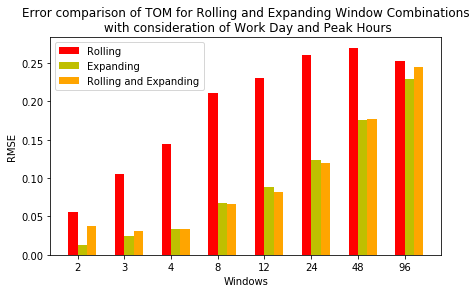

In [12]:
windows = [2, 3, 4, 8, 12, 24, 48, 96]
pm1_rolling = [0.056, 0.105, 0.145, 0.211, 0.23, 0.26, 0.27, 0.253]
pm1_expanding = [0.013, 0.024, 0.034, 0.067, 0.088, 0.124, 0.176, 0.229]
pm1_roll_expanding = [0.038, 0.031, 0.034, 0.066, 0.082, 0.120, 0.177, 0.245]

ind = np.arange(len(pm1_rolling_wp))  # the x locations for the groups
width = 0.20      # the width of the bars

fig, ax = plt.subplots(figsize=(7,4))

rects1 = ax.bar(ind, pm1_rolling, width, color='r')
# ax.plot(pm1_rolling, color='r', alpha=0.4)

rects2 = ax.bar(ind + width, pm1_expanding, width, color='y')
# ax.plot(pm1_expanding, color='y', alpha=0.4)

rects3 = ax.bar(ind + width + width, pm1_roll_expanding, width, color='orange')
# ax.plot(pm1_roll_expanding, color='orange', alpha=0.4)

# add some text for labels, title and axes ticks
ax.set_ylabel('RMSE')
ax.set_xlabel('Windows')
ax.set_title('Error comparison of TOM for Rolling and Expanding Window Combinations\n with consideration of Work Day and Peak Hours')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((windows))


ax.legend((rects1[0], rects2[0], rects3[0]), ('Rolling', 'Expanding', 'Rolling and Expanding'))


plt.show()

<br><br><br>
# PM1 Best Features

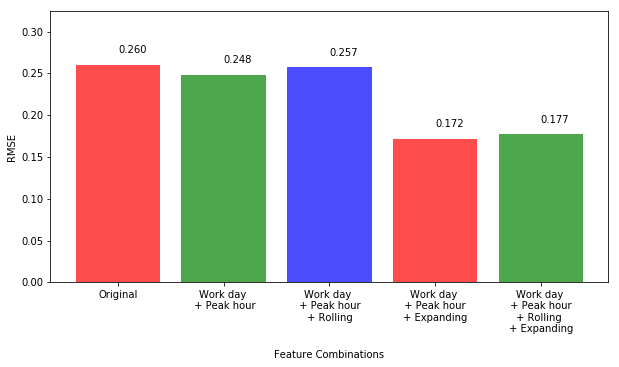

In [34]:
#PM1 Best Features (Original, WP, WP Roll, WP Exp, WP Roll & Exp)
rmse = [0.260, 0.248, 0.257, 0.172, 0.177]
datasets = ['Original', 
            'Work day \n + Peak hour', 
            'Work day \n + Peak hour \n+ Rolling', 
            'Work day \n + Peak hour \n+ Expanding',
            'Work day \n + Peak hour \n+ Rolling \n+ Expanding']

plt.figure(figsize=(10, 5))
plt.margins(0.05, 0.25)

plt.bar(datasets, rmse, align='center', alpha=0.7, color=['r', 'g', 'b'])

for a, b in zip(datasets, rmse):
    lbl = str(b)
    if str(b * 100).split(".")[1] == '0':
        lbl = lbl + "0"
    
    plt.text(a, b, lbl+"\n")

# plt.title("Error Comparison of TOM for Different Setups")
plt.xlabel("\nFeature Combinations")
plt.ylabel("RMSE")

fig.tight_layout()
plt.show()

<br><br><br>
# PM2 Windows

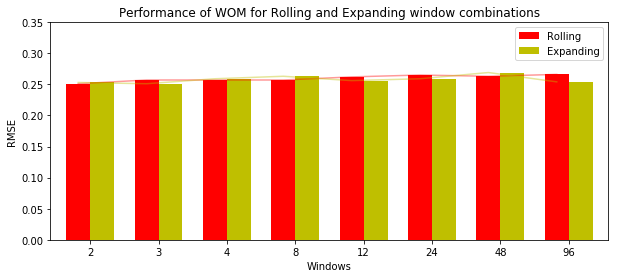

In [14]:
windows = [2, 3, 4, 8, 12, 24, 48, 96]
pm2_rolling = [0.251, 0.257, 0.257, 0.257, 0.262, 0.265, 0.263, 0.266]
pm2_expanding = [0.253, 0.251, 0.259, 0.263, 0.256, 0.259, 0.269, 0.254]

ind = np.arange(len(pm1_rolling_wp))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(10,4))

rects1 = ax.bar(ind, pm2_rolling, width, color='r')
ax.plot(pm2_rolling, color='r', alpha=0.4)

rects2 = ax.bar(ind + width, pm2_expanding, width, color='y')
ax.plot(pm2_expanding, color='y', alpha=0.4)

# add some text for labels, title and axes ticks
ax.set_ylabel('RMSE')
ax.set_xlabel('Windows')
ax.set_title('Performance of WOM for Rolling and Expanding window combinations')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((windows))

ax.legend((rects1[0], rects2[0]), ('Rolling', 'Expanding'))
plt.margins(0.03, 0.3)

plt.show()

<br><br><br>
# PM2 Best Features

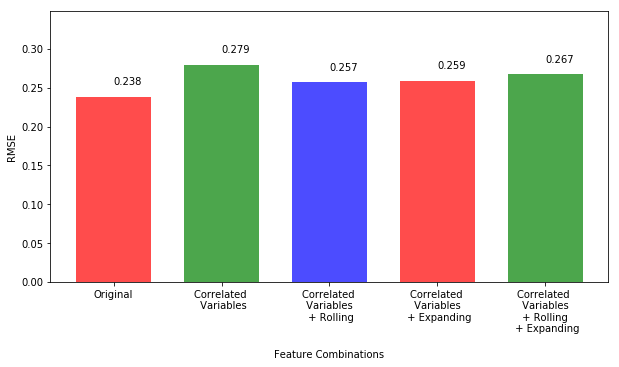

In [35]:
#PM2 Best Features (Original, Correlated, Rolling, Expanding, Correlated with Rollign and Expanding)
rmse = [0.238, 0.279, 0.257, 0.259, 0.267]
datasets = ['Original', 
            'Correlated \n Variables', 
            'Correlated \n Variables \n + Rolling', 
            'Correlated \n Variables \n + Expanding',
            'Correlated \n Variables \n + Rolling \n + Expanding']

plt.figure(figsize=(10, 5))
plt.margins(0.05, 0.25)

plt.bar(datasets, rmse, align='center', alpha=0.7, color=['r', 'g', 'b'], width=0.7)

for a, b in zip(datasets, rmse):
    lbl = str(b)
    if str(b * 100).split(".")[1] == '0':
        lbl = lbl + "0"
    
    plt.text(a, b, lbl+"\n")

plt.xlabel("\nFeature Combinations")
plt.ylabel("RMSE")

fig.tight_layout()
plt.show()

<br><br><br>
# Fusion: Feature vs Decision for All - Best Datasets

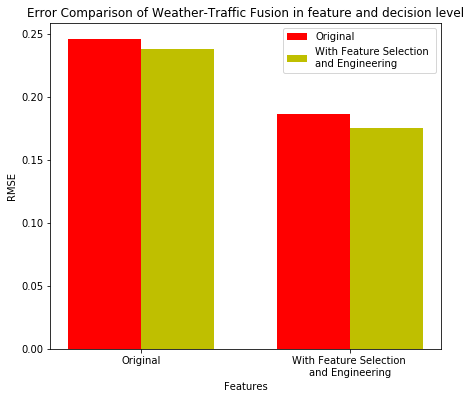

In [36]:
datasets = ['Original', 'With Feature Selection \nand Engineering']
ff_rmse = [0.246, 0.186]
df_rmse = [0.238, 0.175]

# improvement
# FF = (0.246 - 0.238)/.246

ind = np.arange(len(ff_rmse))  # the x locations for the groups
width = 0.35    # the width of the bars

fig, ax = plt.subplots(figsize=(7,6))

rects1 = ax.bar(ind, ff_rmse, width, color='r')
# ax.plot(ff_rmse, color='r', alpha=0.4)

rects2 = ax.bar(ind + width, df_rmse, width, color='y')
# ax.plot(df_rmse, color='y', alpha=0.4)

# add some text for labels, title and axes ticks
ax.set_ylabel('RMSE')
ax.set_xlabel('Features')
ax.set_title('Error Comparison of Weather-Traffic Fusion in feature and decision level')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((datasets))

ax.legend((rects1[0], rects2[0]), (datasets))

plt.show()

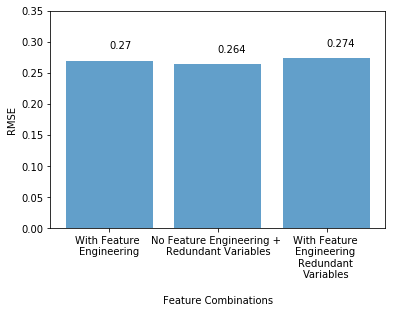

In [17]:
#PM1 Analyzation
rmse = [0.270, 0.264, 0.274]
datasets = ['With Feature \nEngineering', 'No Feature Engineering + \nRedundant Variables', 
            'With Feature \nEngineering \nRedundant \nVariables']

plt.ylim(0, 0.35)

plt.xlabel("\nFeature Combinations")

plt.bar(datasets, rmse, align='center', alpha=0.7)
for a, b in zip(datasets, rmse):
    plt.text(a, b, str(b) + "\n")
    
plt.ylabel("RMSE")
plt.show()

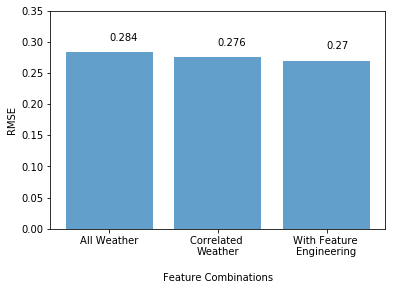

In [18]:
#PM1 Analyzation
rmse = [0.284, 0.276, 0.270]
datasets = ['All Weather', 'Correlated \nWeather', 'With Feature \nEngineering']

plt.ylim(0, 0.35)

plt.xlabel("\nFeature Combinations")

plt.bar(datasets, rmse, align='center', alpha=0.7)
for a, b in zip(datasets, rmse):
    plt.text(a, b, str(b) + "\n")
    
plt.ylabel("RMSE")
plt.show()

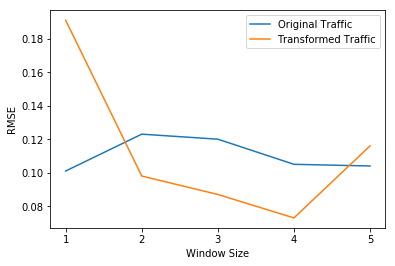

In [19]:
line1 = [0.101, 0.123, 0.120, 0.105, 0.104] #Original Traffic
line2 = [0.191, 0.098, 0.087, 0.073, 0.116] #Transformedraffic
x = np.array(list(range(1, 6)))
plt.plot(x, line1)
plt.plot(x, line2)
plt.xticks(x)
plt.legend(["Original Traffic", "Transformed Traffic"])
plt.xlabel("Window Size")
plt.ylabel("RMSE")

plt.show()

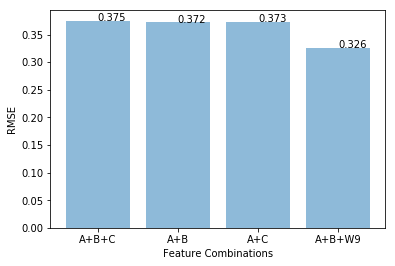

In [20]:
abc = 0.375
ab = 0.372
ac = 0.373
ab9 = 0.326

datasets = ["A+B+C", "A+B", "A+C", "A+B+W9"]
scores = [abc, ab, ac, ab9]

plt.bar(datasets, scores, align='center', alpha=0.5)
for a, b in zip(datasets, scores):
    plt.text(a, b, str(b))
    
plt.xlabel("Feature Combinations")
plt.ylabel("RMSE")
plt.show()

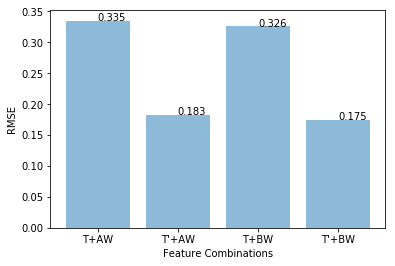

In [21]:
abc = 0.335
ab = 0.183
ac = 0.326
ab9 = 0.175

datasets = ["T+AW", "T'+AW", "T+BW", "T'+BW"]
scores = [abc, ab, ac, ab9]

plt.bar(datasets, scores, align='center', alpha=0.5)
for a, b in zip(datasets, scores):
    plt.text(a, b, str(b))
plt.xlabel("Feature Combinations")
plt.ylabel("RMSE")
plt.show()

In [22]:
output = pd.read_csv("logs/3-TAFT/fc_output_Taft Ave._2015.csv", skipinitialspace=True)
output.head()

startIndex = 5844
endIndex = 6899

#1 whole month
dt = output.dt[startIndex-2:endIndex-1]
actual = output.Actual[startIndex-2:endIndex-1]
predicted = output.Predicted[startIndex-2:endIndex-1]


plt.plot(predicted)
plt.plot(actual)
plt.legend(["Predicted Traffic", "Actual Traffic"])
plt.show()

FileNotFoundError: File b'logs/3-TAFT/fc_output_Taft Ave._2015.csv' does not exist

In [ ]:
output = pd.read_csv("logs/7-TAFT (Orig Traffic, temp-windspd,temp4,press4)/fc_output_Taft Ave._2015.csv", skipinitialspace=True)
output.head()

startIndex = 5844
endIndex = 6899

#1 whole month
dt = output.dt[startIndex-2:endIndex-1]
actual = output.Actual[startIndex-2:endIndex-1]
predicted = output.Predicted[startIndex-2:endIndex-1]


plt.plot(predicted)
plt.plot(actual)
plt.legend(["Predicted Traffic", "Actual Traffic"])
plt.show()

In [ ]:
ROAD = "Vicente Cruz"
YEAR = "2015"
EXT = ".csv"

fc_results = pd.read_csv("../output/fc_" + ROAD + "_" + YEAR + EXT, skipinitialspace=True)

line1 = fc_results.Actual[1117:1788]
line2 = fc_results.Predicted[1117:1788]

font = {'family' : 'normal',
        'weight': 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(figsize=(10,5))
linestyles = ['-', '--', '-.', ':']

ax.plot(line1, color='red', alpha=0.7, label='Actual Traffic')

fig.canvas.draw()


labels = [""]
for d in fc_results.dt[1110:1789]:
    if "00:00:00" in d:
        temp = d.split(" ")[0].split("-")
        temp = "Oct" + temp[2]
        labels.append(temp)
        print(temp)
           
ax.set_xticklabels(labels)    
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(["Light \nTraffic", "Moderate \nTraffic", "Heavy \nTraffic"])

ax.plot(line2, linestyle=linestyles[1], color='blue', alpha=0.7, label='Predicted Traffic')



ax.legend(loc='upper right')
